## Unimodal Training before Multimodal Training

### Imports and class name extraction

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input/upmcfood101/texts'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/upmcfood101/texts/train_titles.csv
/kaggle/input/upmcfood101/texts/test_titles.csv


### Dataset organization

In [2]:
image_root = '/kaggle/input/upmcfood101/images/'
datalink = {
    'train': '/kaggle/input/upmcfood101/texts/train_titles.csv',
    'test' : '/kaggle/input/upmcfood101/texts/test_titles.csv'
}
col_Names=["Images", "Titles", "Labels"]
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

### Dataloader and Augmentation

In [3]:
classnames = fast_scandir('/kaggle/input/upmcfood101/images/test')
n_classes = len(classnames)
print('Number of classes: ',n_classes)

print(classnames[0].split('/')[-1])
for iter1 in range(len(classnames)):
    classnames[iter1] = classnames[iter1].split('/')[-1]

classes =  sorted(classnames)
print(classes)
col_Names=["Images", "Titles", "Labels"]

train_df = pd.read_csv(datalink['train'], names=col_Names)
test_df = pd.read_csv(datalink['test'], names=col_Names)

for iter1 in range(len(train_df)):
    train_df['Labels'][iter1] = train_df['Labels'][iter1].split('\n')[0]
    train_df['Labels'][iter1] = classes.index(train_df['Labels'][iter1])

for iter1 in range(len(test_df)):
    test_df['Labels'][iter1] = test_df['Labels'][iter1].split('\n')[0]
    test_df['Labels'][iter1] = classes.index(test_df['Labels'][iter1])

train_df.head()

Number of classes:  101
macarons
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_a

/tmp/ipykernel_23/264169387.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df['Labels'][iter1] = train_df['Labels'][iter1].split('\n')[0]
/tmp/ipykernel_23/264169387.py:18: FutureWarning: ChainedAssignmentError: behaviour will ch

,Images,Titles,Labels
0,apple_pie_851.jpg,Crock-Pot Ladies Crock-Pot Apple Pie Moonshine,0
1,apple_pie_140.jpg,Mom's Maple-Apple Pie Recipe | Taste of Home,0
2,apple_pie_858.jpg,Cookin&#8217; Canuck &#8211; Baked Apple Pie E...,0
3,apple_pie_449.jpg,Dutch Apple Pie Recipe | Just A Pinch Recipes,0
4,apple_pie_695.jpg,Our Share of the Harvest &raquo; Grandma&#8217...,0


In [4]:
for iter1 in range(len(train_df)):
    if len(train_df['Titles'][iter1]) < 2:
        print(train_df['Titles'][iter1], iter1)
        train_df = train_df.drop(iter1)

print(len(train_df), len(test_df))

: 39338
67971 22716


## Text Classification Module

In [5]:
!pip install torchtext==0.5.0

import torch
from torchtext.data.utils import get_tokenizer
import collections
import torchtext
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sn

tokenizer = get_tokenizer('basic_english')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.9 MB/s eta 0:00:00


## Details of Texts

------------Description of the data-------------
                 Images                                        Titles  Labels
count             67971                                         67971   67971
unique            67971                                         47832     101
top     waffles_276.jpg  Cake Batter Ice Cream Recipe | POPSUGAR Food      62
freq                  1                                           132     713

------------Missing values in the data-------------
Images    0
Titles    0
Labels    0
dtype: int64


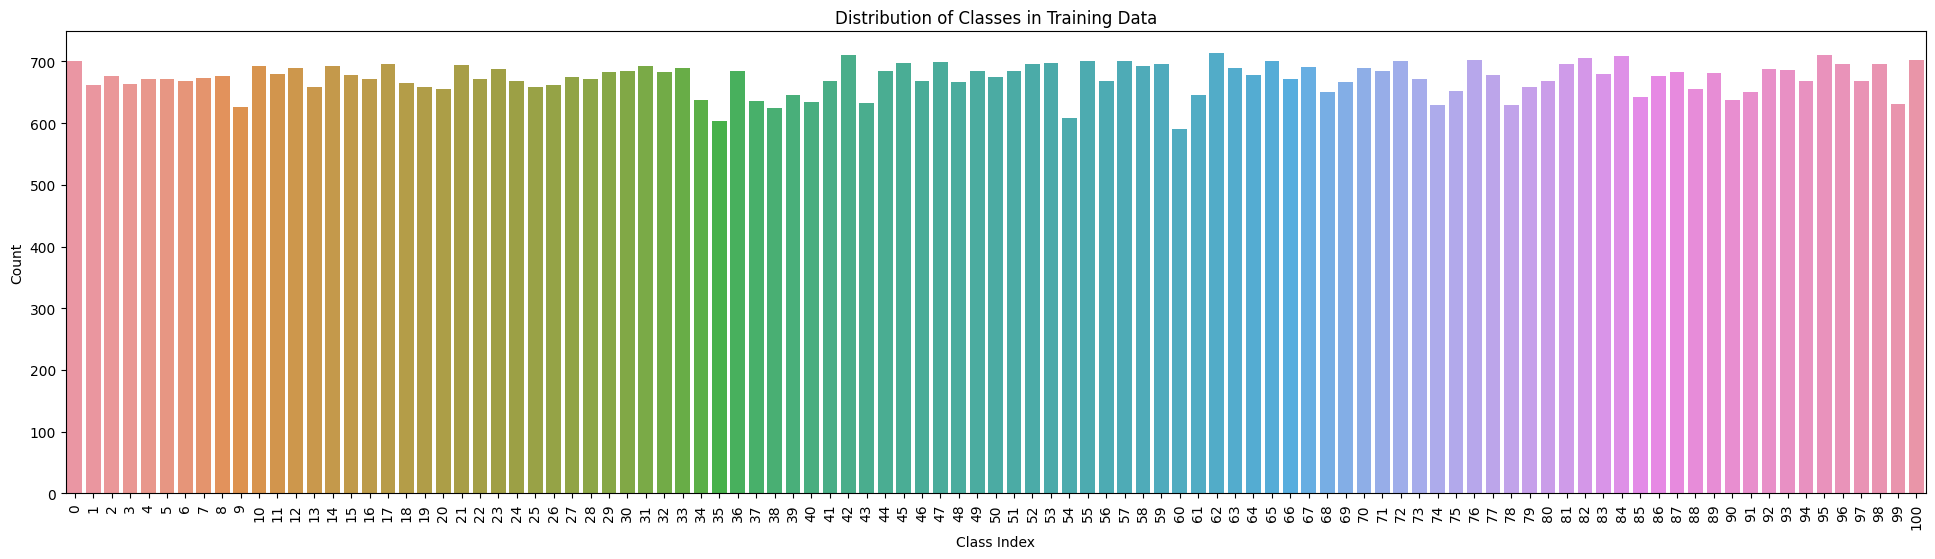

In [6]:
print('------------Description of the data-------------')
print(train_df.describe())

# Check for missing values
print('\n------------Missing values in the data-------------')
print(train_df.isnull().sum())

plt.figure(figsize=(24, 6))
sn.countplot(x='Labels', data=train_df)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.show()

## Vocabulary of all Tokens

In [7]:
class TextDataset(Dataset):
  def __init__(self,df):
    self.n_samples = len(df)
    self.dataframe = df

  def __getitem__(self, index):
    row = self.dataframe.iloc[index]
    return row['Labels'], str(row['Titles'])

  def __len__(self):
    return self.n_samples

train_dataset = TextDataset(train_df)
test_dataset = TextDataset(test_df)

counter = collections.Counter()

for (label, other_inputs) in train_dataset:
    counter.update(torchtext.data.utils.ngrams_iterator(tokenizer(other_inputs),ngrams=1))
vocab = torchtext.vocab.Vocab(counter, min_freq=1)

In [8]:
vocab_size = len(vocab)
print(f"Vocab size is {vocab_size}")

def encode(x):
    return [vocab.stoi[s] for s in tokenizer(x)]

def decode(x):
    return [vocab.itos[i] for i in x]

Vocab size is 26178


In [9]:
def padify(b):
    v = [encode(x[1]) for x in b]
    l = max(map(len,v))
    return ( # tuple of two tensors - labels and features
        torch.LongTensor([t[0]-1 for t in b]),
        torch.stack([torch.nn.functional.pad(torch.tensor(t),(0,l-len(t)),mode='constant',value=0) for t in v])
    )

## RNN Model

In [10]:
class NNClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.layer1 = torch.nn.Linear(embed_dim,hidden_dim)
        self.layer2 = torch.nn.Linear(hidden_dim,hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, num_class)
        self.lru = torch.nn.LeakyReLU()

    def forward(self, x):
        batch_size = x.size(0)
        x = self.embedding(x)
        x = self.layer1(x)
        x = self.lru(x)
        x = self.layer2(x)
        x = self.lru(x)
        return self.fc(x.mean(dim=1))

## Text Dataloader

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, collate_fn=padify, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Training

In [12]:
model = NNClassifier(vocab_size,128,200,len(classes)).to(device)
lr = 0.001
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
loss_fn = loss_fn.to(device)
model.train()

for epoch in range(10):
    total_loss,acc,count,i = 0,0,0,0
    for labels,features in train_loader:
        optimizer.zero_grad()
        features, labels = features.to(device), labels.to(device)
        out = model(features)
        #print(out.shape, labels.shape)
        loss = loss_fn(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
        i+=1
    print("Epoch " + f"{epoch}: acc={acc.item()/count}")

Epoch 0: acc=0.5079372085153963
Epoch 1: acc=0.801665416133351
Epoch 2: acc=0.8183048653102059
Epoch 3: acc=0.8314722455164703
Epoch 4: acc=0.8413293904753498
Epoch 5: acc=0.8529814185461447
Epoch 6: acc=0.8615586058760354
Epoch 7: acc=0.8717099939680157
Epoch 8: acc=0.8823321710729576
Epoch 9: acc=0.8915272689823601


In [13]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, collate_fn=padify, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, collate_fn=padify, shuffle=False)

model.eval()

output_test = []
for target, data in test_loader:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data) # Feed Network
        output_test.extend(output.data.cpu().numpy())

output_train = []
for target, data in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data) # Feed Network
        output_train.extend(output.data.cpu().numpy())
    
print(len(output_test),len(output_train))
print(output_test[0].shape)

prediction_test_df = pd.DataFrame(output_test)
prediction_train_df = pd.DataFrame(output_train)

#prediction_train_df.head()

22716 67971
(101,)


## Save CSV files

In [14]:
train1_df = pd.concat([train_df, prediction_train_df], axis=1)
test_df_save = pd.concat([test_df, prediction_test_df], axis=1)

train1_df.head()

,Images,Titles,Labels,0,1,2,3,4,5,6,...,91,92,93,94,95,96,97,98,99,100
0,apple_pie_851.jpg,Crock-Pot Ladies Crock-Pot Apple Pie Moonshine,0,-2.428174,-0.716513,-1.393932,-1.445138,-2.735707,0.255293,-1.227859,...,-1.674568,-3.047418,-0.039955,-0.973345,-1.944534,-2.005103,-1.716720,-1.394992,-2.493656,-18.945679
1,apple_pie_140.jpg,Mom's Maple-Apple Pie Recipe | Taste of Home,0,-1.201577,-0.129055,-3.151912,-3.145733,-1.827629,-1.248257,-2.701943,...,-1.921065,-1.005522,-0.596233,-0.777625,-0.449589,-2.835437,-1.061875,-1.930308,-1.332734,-16.843304
2,apple_pie_858.jpg,Cookin&#8217; Canuck &#8211; Baked Apple Pie E...,0,-1.812280,-5.008090,-4.939887,-5.081469,-5.625733,-1.841929,-6.446833,...,0.672923,-3.535914,-2.401711,-1.654135,-4.156447,-9.081838,-5.433847,-4.021327,-1.518717,-35.352528
3,apple_pie_449.jpg,Dutch Apple Pie Recipe | Just A Pinch Recipes,0,0.005793,-0.144258,-1.703959,-1.450145,-2.241200,-1.372455,-1.151806,...,-3.041842,-0.536162,-1.505571,0.112371,-0.704045,-2.344195,-3.623490,-1.172556,-1.294111,-21.095592
4,apple_pie_695.jpg,Our Share of the Harvest &raquo; Grandma&#8217...,0,-4.573693,-3.998559,-3.359232,-4.144498,-8.028936,-6.882055,-4.324083,...,-4.521409,-4.025358,-3.545596,-1.139970,-4.336815,-5.116168,-7.100971,-2.531950,-6.248171,-46.718246


In [15]:
train_df_save = []
valid_df_save = []

split_counter = 0
for iter1 in range(len(train1_df)):
    split_counter = split_counter + 1
    if split_counter%10 ==0:
        valid_df_save.append(train1_df.iloc[iter1])
    train_df_save.append(train1_df.iloc[iter1])

#print(test_df_save.columns, len(train1_df), np.size(train_df_save), split_counter)
train_df_save = pd.DataFrame(train_df_save, columns=test_df_save.columns)
train_df_save = train_df_save.dropna()

valid_df_save = pd.DataFrame(valid_df_save, columns=test_df_save.columns)
train_df_save.to_csv('train.csv',index=False)
test_df_save.to_csv('test.csv',index=False)
valid_df_save.to_csv('valid.csv',index=False)

valid_df_save.head()

,Images,Titles,Labels,0,1,2,3,4,5,6,...,91,92,93,94,95,96,97,98,99,100
9,apple_pie_158.jpg,Apple Pie Grilled Cheese Recipe: Cheddar,0,-1.143576,-1.108440,-4.357209,-6.214904,-2.084926,-4.094921,-5.627248,...,-4.860799,-2.332830,0.433912,-0.237159,-2.513320,-3.128082,-1.670550,-2.461486,-2.014486,-27.156395
19,apple_pie_958.jpg,apple pie cookies | smitten kitchen,0,-4.314074,0.607831,-2.657062,-3.305398,-1.991319,-0.883437,-2.355562,...,-3.655601,-2.956768,-0.543903,-0.704563,-2.531600,-0.682654,0.183727,-1.132306,-1.882285,-20.035025
29,apple_pie_130.jpg,APPLE PIE JAM,0,-3.035569,0.961816,-0.272204,-0.719758,-1.891337,-0.450665,-2.891466,...,-2.570620,-2.537751,-0.239245,0.335503,-2.613521,0.388985,-2.478908,0.193861,-2.739310,-15.924957
39,apple_pie_282.jpg,Crunchy Caramel Apple Pie Recipe | Spoonful,0,-2.588492,-0.851133,-3.679092,-3.204058,-3.238842,-0.483632,-1.277496,...,-1.879839,-3.763354,-1.202074,-0.694276,-2.493545,-2.409227,-3.746000,-1.848163,-0.945987,-24.127102
49,apple_pie_141.jpg,Caramel Crunch Apple Pie Recipe - Baking.Food.com,0,-2.385232,-0.385387,-4.671329,-5.267313,-3.793357,-0.447348,-2.298692,...,-2.759793,-3.214911,-0.499843,-1.786779,-2.574223,-2.863248,-1.207029,-3.477342,-1.220052,-24.541433


## Test Accuracy

In [16]:
total_loss,acc,count,i = 0,0,0,0
for labels,features in test_loader:
    features, labels = features.to(device), labels.to(device)
    out = model(features)
    loss = loss_fn(out,labels)
    total_loss+=loss
    _,predicted = torch.max(out,1)
    acc+=(predicted==labels).sum()
    count+=len(labels)
    i+=1
print("Test " + f"acc={acc.item()/count}")

Test acc=0.8335534425074838


### Save model

In [17]:
PATH = "./NN_text_model.pt"
torch.save(model.state_dict(), PATH)

import pickle

with open('objs.pkl', 'wb') as f:
    pickle.dump(classes, f)

'''
# Getting back the objects:
with open('objs.pkl') as f: 
    vocab_size, classes = pickle.load(f)
'''

"\n# Getting back the objects:\nwith open('objs.pkl') as f: \n    vocab_size, classes = pickle.load(f)\n"